# Banging a black hole

In [2]:
import numpy as np
from scipy.special import lambertw
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
})

## Potentials

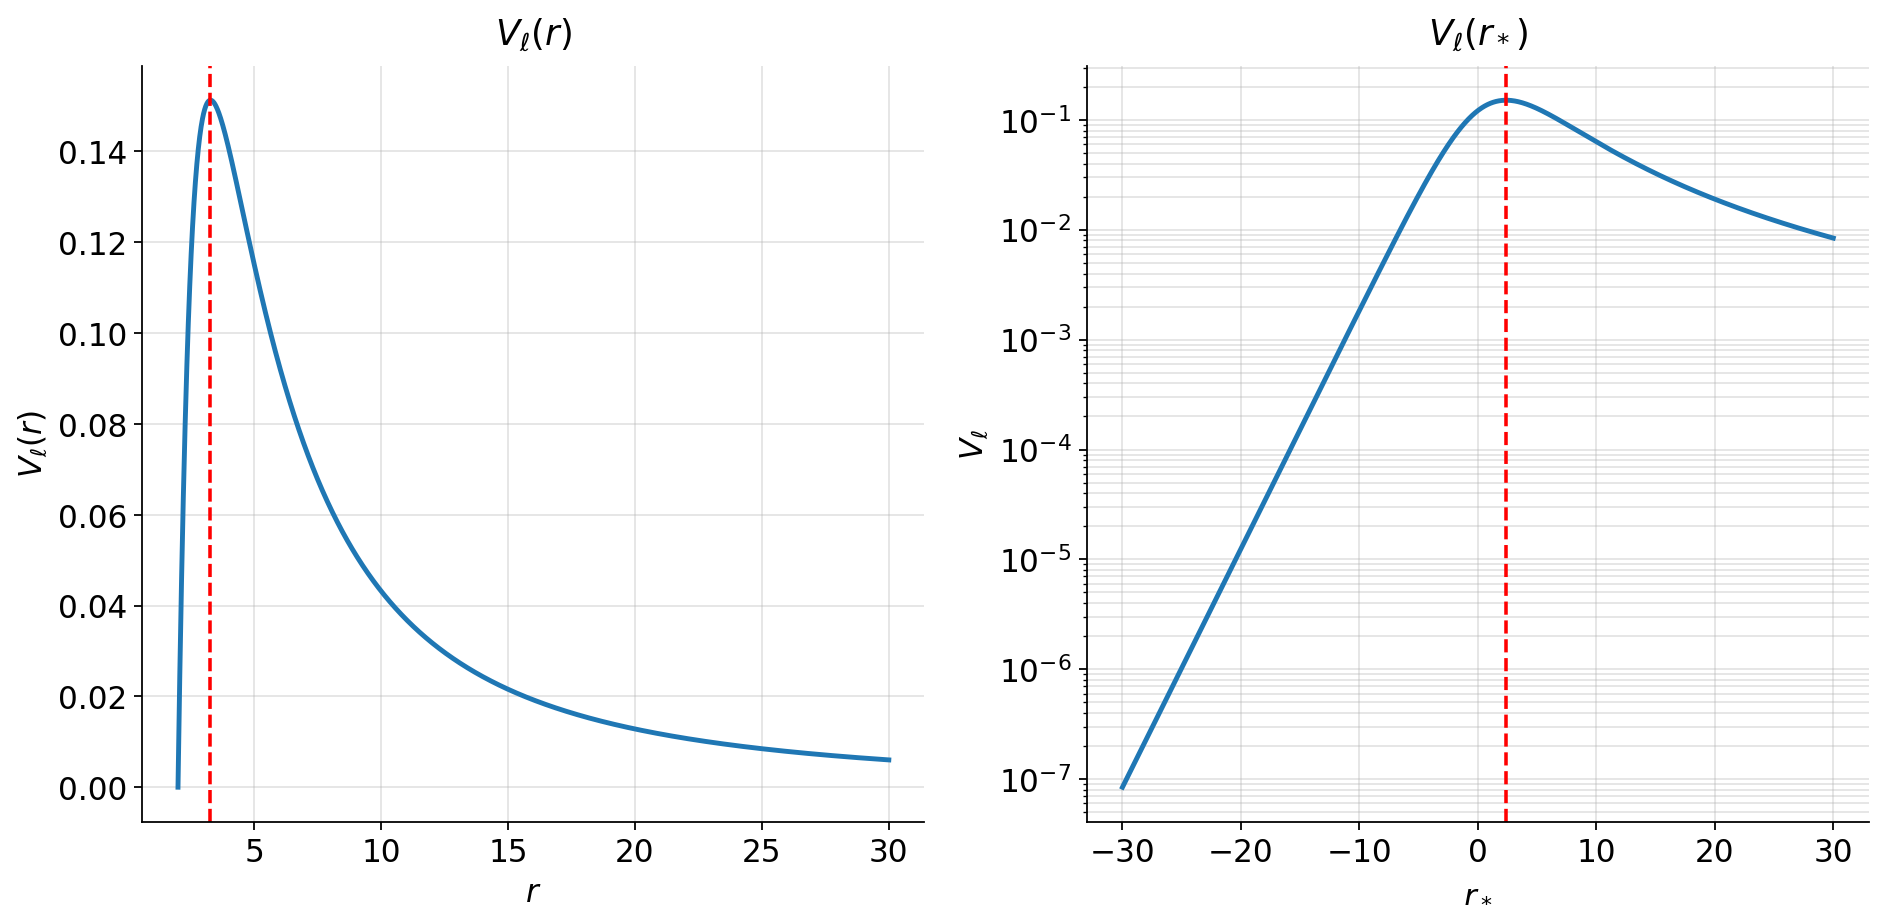

In [12]:
# -----------------------------
# Parameters
# -----------------------------
M = 1
ell = 2
rs = 2 * M 

# -----------------------------
# Tortoise inverse r(r_*)
# -----------------------------
def r_from_rstar(r_star, M=M):
    r_star = np.asarray(r_star, dtype=float)
    rs = 2 * M
    x = r_star / rs - 1.0  # need W(exp(x))

    w = np.empty_like(x)
    mask = x < 700.0  # safe for exp in float64

    w[mask] = lambertw(np.exp(x[mask]), k=0).real

    if np.any(~mask):
        L1 = x[~mask]
        L2 = np.log(L1)
        w[~mask] = (
            L1 - L2
            + L2 / L1
            + (L2 * (-2 + L2)) / (2 * L1**2)
            + (L2 * (6 - 9*L2 + 2*L2**2)) / (6 * L1**3)
        )

    return rs * (1.0 + w)

# -----------------------------
# Regge–Wheeler potential
# -----------------------------
def V_RW(r, M=M, ell=ell):
    r = np.asarray(r, dtype=float)
    f = 1.0 - 2.0 * M / r
    return f * (ell * (ell + 1) / r**2 - 6.0 * M / r**3)

# -----------------------------
# Data for both plots
# -----------------------------
# V(r_*)
r_star = np.linspace(-30, 30, 2001)
r_of_rstar = r_from_rstar(r_star)
V_star = V_RW(r_of_rstar)
i_star = np.argmax(V_star)
r_star_peak = r_star[i_star]

# V(r)
r = np.linspace(rs * (1.0 + 1e-6), 30.0, 2000)
V_r = V_RW(r)
i_r = np.argmax(V_r)
r_peak = r[i_r]

# -----------------------------
# Side-by-side plots
# -----------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=160)

# Left: V(r) on linear scale
ax1.plot(r, V_r, lw=2.2)
ax1.axvline(r_peak, color="red", ls="--", lw=1.6)
ax1.set_title(rf"$V_\ell(r)$", pad=10)
ax1.set_xlabel(r"$r$")
ax1.set_ylabel(r"$V_\ell(r)$")
ax1.grid(True, alpha=0.35)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# Right: V(r_*) on log scale
ax2.set_yscale("log")
ax2.plot(r_star, V_star, lw=2.2)
ax2.axvline(r_star_peak, color="red", ls="--", lw=1.6)
ax2.set_title(rf"$V_\ell(r_*)$", pad=10)
ax2.set_xlabel(r"$r_*$")
ax2.set_ylabel(r"$V_\ell$")
ax2.grid(True, which="both", alpha=0.35)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

fig.tight_layout()
plt.savefig("potential.png")
plt.show()


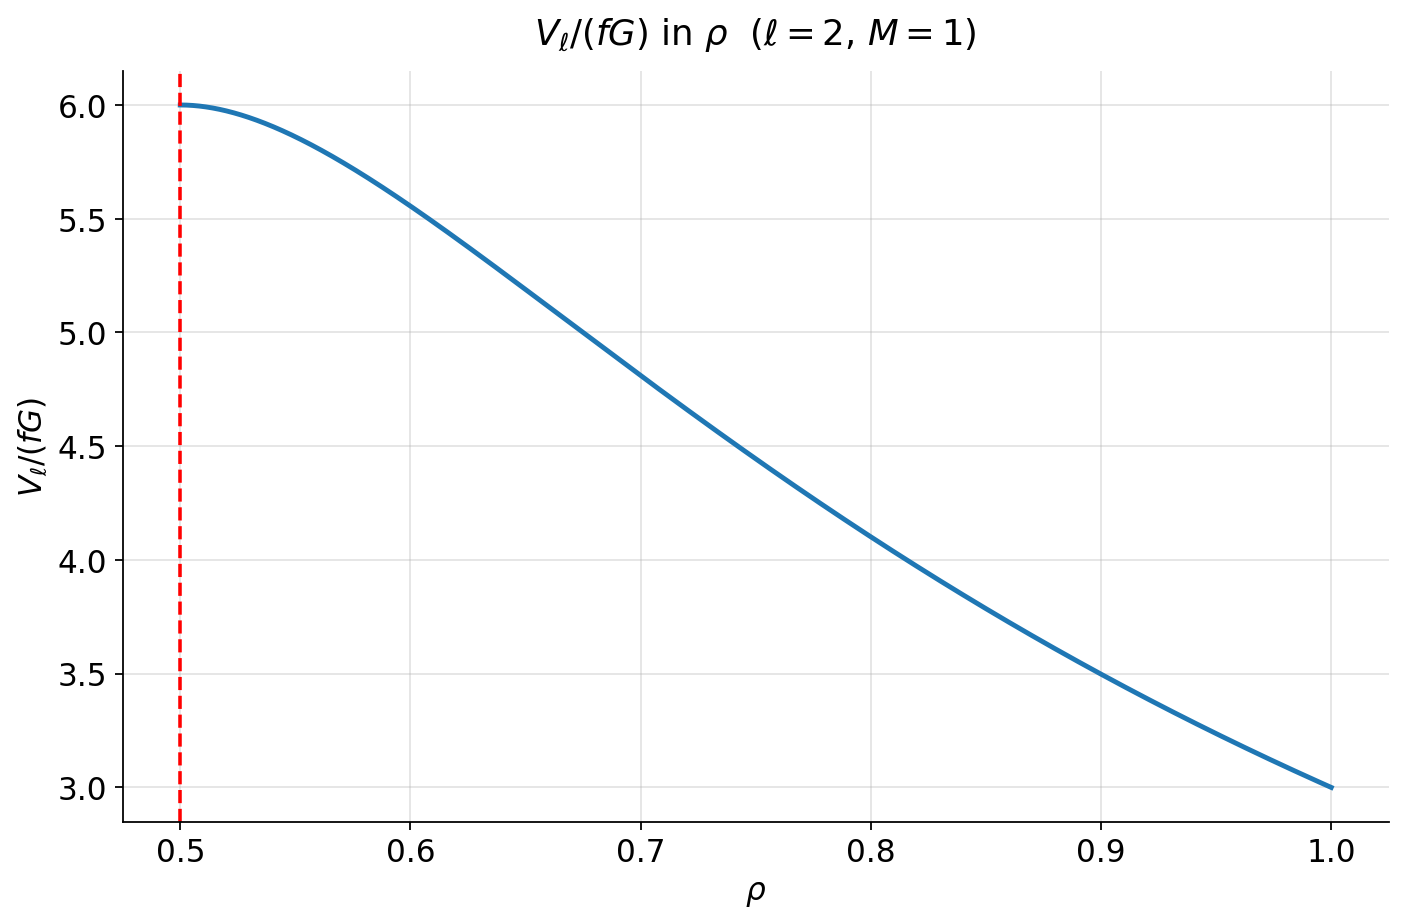

In [11]:
# -----------------------------
# Potential in rho
#   V/(fG) = (L*rho - 3(1-rho)) / (2M rho^3)
# -----------------------------
def V_over_fG(rho, M=M, ell=ell):
    rho = np.asarray(rho, dtype=float)
    L = ell * (ell + 1)
    return (L * rho - 3.0 * (1.0 - rho)) / (2.0 * M * rho**3)

# Domain: rho in [1/2, 1]
rho = np.linspace(0.5, 1.0, 2000)
y = V_over_fG(rho)

# Peak location (for dashed line)
rho_peak = rho[np.argmax(y)]

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(9, 6), dpi=160)
ax.plot(rho, y, lw=2.2)
ax.axvline(rho_peak, color="red", ls="--", lw=1.6)

ax.set_title(rf"$V_\ell/(fG)$ in $\rho$  ($\ell={ell}$, $M={M}$)", pad=12)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$V_\ell/(fG)$")
ax.grid(True, alpha=0.35)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.tight_layout()
plt.savefig("rescaled_potential.png")
plt.show()

## Time-domain solution

In [168]:
import numpy as np
import matplotlib.pyplot as plt

def local_power_index(t, phi):
    """
    Computes the local power index p = d/d(log t) [log |phi|]
    using a simple finite-difference scheme.
    Returns an array p of the same size as t and phi.
    """
    # Precompute logs
    lt = np.log(t)
    lp = np.log(np.abs(phi))
    # Allocate output
    p = np.empty_like(lp)
    # Forward difference at the left boundary
    p[0] = (lp[1] - lp[0]) / (lt[1] - lt[0])
    # Central difference for the interior points
    p[1:-1] = (lp[2:] - lp[:-2]) / (lt[2:] - lt[:-2])
    # Backward difference at the right boundary
    p[-1] = (lp[-1] - lp[-2]) / (lt[-1] - lt[-2])    
    return p

def initialize(x, **kwargs):
    '''
    u[0,:] = pi
    u[1,:] = psi
    u[2,:] = phi
    '''
    u = np.zeros((3, len(x)))
    x0 = kwargs.get('x0', 0.0)
    sigma = kwargs.get('sigma', 1.0)
    u[2, :] = np.exp(-(x-x0)**2/(2*sigma**2))
    u[1, :] = - (x - x0) / sigma**2 * u[2, :]
    u[0, :] = 0.0
    return u

# 8th order FD center stencil
KERNEL = np.array([-3, 32, -168, 672, 0, -672, 168, -32, 3], dtype=float) / 840.0
# 8th order FD one-sided boundary stencil
B = np.array([
    [-2283.0, 6720.0, -11760.0, 15680.0, -14700.0,  9408.0, -3920.0,  960.0, -105.0],
    [ -105.0, -1338.0,  2940.0, -2940.0,   2450.0, -1470.0,   588.0, -140.0,   15.0],
    [   15.0,  -240.0,  -798.0,  1680.0,  -1050.0,   560.0,  -210.0,   48.0,   -5.0],
    [   -5.0,    60.0,  -420.0,  -378.0,   1050.0,  -420.0,   140.0,  -30.0,    3.0],
], dtype=float) / 840.0

def diff(u, h):
    du = np.convolve(u, KERNEL, mode="same")
    # boundaries via matrix-vector products
    du[:4] = B @ u[:9]
    du[-4:] = -(B[::-1] @ u[-1:-10:-1])  # mirrored one-sided stencils
    return du / h

def rhs(u, coefs, h):
    '''
    u[0,:] = pi
    u[1,:] = psi
    u[2,:] = phi
    '''
    rhs_val = np.zeros_like(u)
    rhs_val[2, :] = coefs[0, :] * u[0, :] + coefs[1, :] * u[1, :]
    rhs_val[1, :] = diff(rhs_val[2, :], h)
    rhs_val[0, :] = diff(coefs[0, :] * u[1, :] + coefs[1, :] * u[0, :], h) + coefs[2, :] * u[2, :]
    
    return rhs_val

def set_coefs(case, x, **kwargs):
    coefs = np.zeros((3, len(x)))
    ell = kwargs.get('ell', 2)
    M = kwargs.get('M', 0.5)

    if case=='Minimal_Gauge':
        coefs[0, :] = x**3/(8.*M)
        coefs[1, :] = coefs[0,:]*(-1 + 2./x**2*(1-x)**2)
        coefs[2, :] = (3*(1-x) - ell*(ell+1)*x)/(2*M*x**3)

    elif case=='CMC':
        K = kwargs.get('K', 1)
        C = kwargs.get('C', 1)

        coefs[0, :] = (9*C**2*(-1 + x)**6 + 48*C*K*M**3*(-1 + x)**3*x**3 + 16*M**4*x**3*(-9 + 36*x - 45*x**2 + 2*(9 + 2*K**2*M**2)*x**3))/(288.*M**5*x**4)
        coefs[1, :] = -((coefs[0,:]*(3*C*(-1 + x)**3 + 8*K*M**3*x**3))/np.sqrt(144*M**4*(-1 + x)**2*x**3*(-1 + 2*x) + (3*C*(-1 + x)**3 + 8*K*M**3*x**3)**2))
        coefs[2, :] = (3 - (3 + ell + ell**2)*x)/(2.*M*x**3)
 
    else:
        raise ValueError(f"Invalid case: {case}")

    return coefs

def wave1dsolve(initial, rhs, coefs, h, dt, nsteps):
    """
    Solve the wave equation
    """
    data = np.zeros(((nsteps+1,)+initial.shape))
    data[0, :, :] = initial
    for i in range(1, nsteps+1):
        data[i, :, :] = rk4(data[i-1, :, :], rhs, coefs, h, dt)
    print("Finished evolution at t = "+str(dt*nsteps))
    return data

def evolve(n,dt,endtime, gauge="Minimal_Gauge", **kwargs):
    rho  = np.linspace(0.5,1,n)
    h = rho[10]-rho[9]
    nsteps = int(endtime/dt)
    initial=initialize(rho, x0=0.75, sigma=0.02)
    coefs = set_coefs(gauge, rho, **kwargs)
    data = wave1dsolve(initial, rhs, coefs, h, dt, nsteps)
    return rho, data[:,2,:]

def rk4(cur, rhs, coefs, h, dt):
    nex = np.copy(cur)
    k1 = dt * rhs(nex,        coefs, h)
    k2 = dt * rhs(nex+0.5*k1, coefs, h)
    k3 = dt * rhs(nex+0.5*k2, coefs, h)
    k4 = dt * rhs(nex+k3,     coefs, h)
    nex += (k1+2.*(k2+k3)+k4)/6.
    return nex

In [176]:
%%time 
n=400;dt=0.03;endtime=1000;
t=np.linspace(0,endtime,int(endtime/dt)+1)

rho, u=evolve(n,dt, endtime, ell=2, gauge="CMC", M=1, K=0.4, C=2)

Finished evolution at t = 999.99
CPU times: user 3.85 s, sys: 109 ms, total: 3.96 s
Wall time: 4 s


In [177]:
%%time 
n=400;dt=0.008;endtime=1000;
t=np.linspace(0,endtime,int(endtime/dt)+1)

rho, u=evolve(n,dt, endtime, ell=2, gauge="Minimal_Gauge", M=1)

Finished evolution at t = 1000.0
CPU times: user 14.7 s, sys: 375 ms, total: 15 s
Wall time: 15.8 s


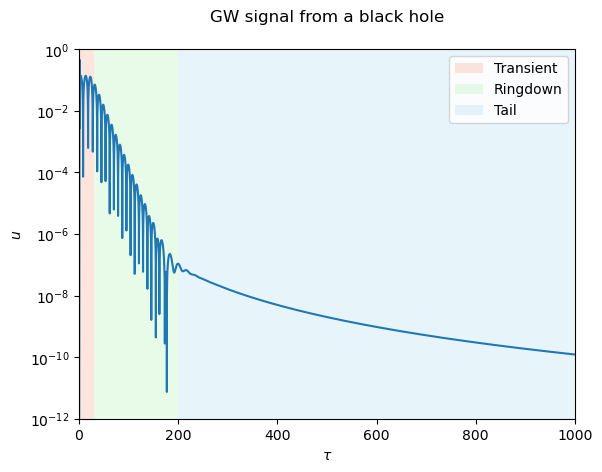

In [178]:
plt.semilogy(t[::4],np.abs(u[::4,-1]))
# plt.semilogy(t[::2],np.abs(u[::2,-40]))
plt.title("GW signal from a black hole",pad=20)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$u$')

bounds=[30,200,1000]
plt.axvspan(0, bounds[0], facecolor='coral', alpha=0.2, label='Transient')
plt.axvspan(bounds[0], bounds[1], facecolor='lightgreen', alpha=0.2, label='Ringdown')
plt.axvspan(bounds[1], bounds[2], facecolor='skyblue', alpha=0.2, label='Tail')
plt.xlim(0, 1000)
plt.ylim(1e-12,1)
plt.legend()
plt.savefig("perturbations.png",dpi=150)

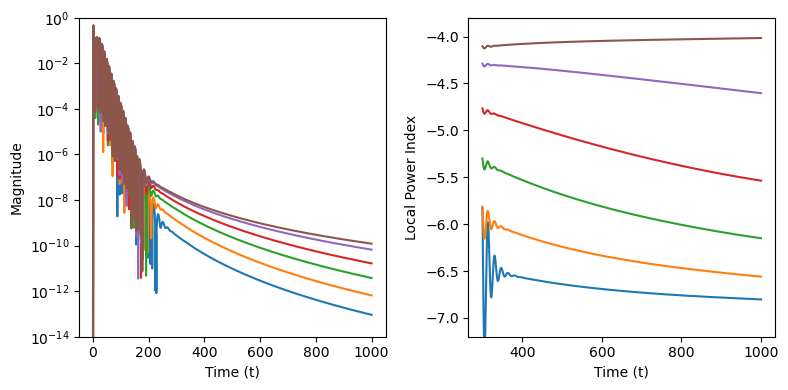

In [179]:
mask = t > 300
points = [-40,-20,-10,-5,-2,-1]
rates=[]
for p in points:
    rates.append(local_power_index(t[mask][::20], u[mask,p][::20]))
rates = np.array(rates)

fig, axes = plt.subplots(1, 2, figsize=(8, 4)) 

# Semilog plot
axes[0].set_ylim(1e-14, 1)
axes[0].set_xlabel("Time (t)")
axes[0].set_ylabel("Magnitude")
for p in points:
    axes[0].semilogy(t, np.abs(u[:,p]))

# Decay rates
for r in rates:
    axes[1].plot(t[mask][::20],r)
axes[1].set_xlabel("Time (t)")
axes[1].set_ylabel("Local Power Index")
axes[1].set_ylim(-7.2,-3.8)

# Adjust layout
plt.tight_layout()
plt.savefig("decay_rates.png", dpi=150)
plt.show()